# RK methods for higher-order ODEs

If we have a higher-order ODE, we can transform it into a system of first-order ODEs, which we can solve with the standard RK method.

Consider for example the ODE
$$y''(x)+P(x)y'(x)+Q(x)y(x)=F(x)\,.$$
We introduce the functions
$$w_1(x)=y(x)\,,\quad w_2(x)=y'(x)=w_1'(x)\,.$$
With this, the ODE can be written as
$$w_1'=w_2\,,\qquad w_2'=F(x)-P(x)w_2-Q(x)w_1\,.$$
In matrix form, this becomes
$$\vec{w}'=A \vec{w}+\vec{b}F(x)\quad\text{~with~}\quad A=\begin{pmatrix}0&1\\-Q(x)&-P(x)\end{pmatrix}\,,~~\vec{w}=\begin{pmatrix}w_1\\w_2\end{pmatrix}\,,~~\vec{b}=\begin{pmatrix}0\\1\end{pmatrix}$$
Now we can apply the RK method to each $w_i$ individually. For example for the first-order RK method:
$$\vec{w}(x_n+h):=\vec{w}(x_{n+1})\approx\vec{w}(x_n)+h \vec{w}'(x_n)=\vec{w}(x_n)+h(A \vec{w}(x_n)+\vec{b}F(x_n)):=\vec{w}(x_n)+h\vec{k}_1$$

## Example for initial value problem
$$y''(x)+4y(x)=0\,,\quad y(0)=0\,,\quad y'(0)=2$$
The exact solution is $y(x)=\sin(2x)$.

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [3]:
def rk1(A, b, f, x_n, w_n, h=1e-2):
    k_1 = jnp.einsum('ij,j->i', A, w_n) + b * f(x_n)
    return w_n + h * k_1

In [6]:
def f(x):
    return 0
    
A = jnp.array([[0., 1.], [-4., 0.]])
b = jnp.array([0., 1.])
h = 1e-2

xs = jnp.arange(0, 2 * jnp.pi, h)
ws = [jnp.array([0., 2.])]

for x, w in zip(xs, ws):
    ws.append(rk1(A, b, f, x, w, h))

ys = [w[0] for w in ws]
ys_exact = jnp.sin(2 * xs)

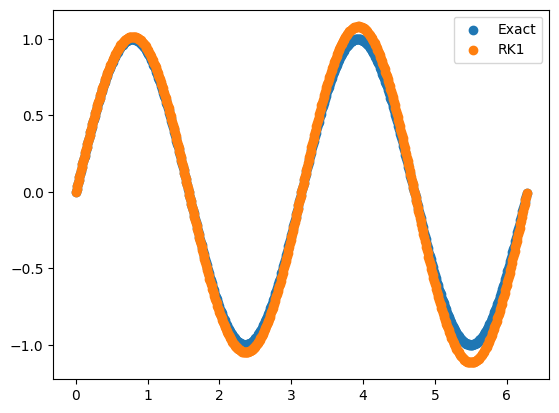

In [7]:
plt.scatter(xs, ys_exact, label="Exact");
plt.scatter(xs, ys[:-1], label="RK1");
plt.legend()

## Example for Boundary Value ODE (Shooting Method)

We consider the cannon shooting example:
$$y''(x)= \text{const}=-10\,,\quad y(0)=0\,,\quad y(1)=0$$
The exact solution is $y(x)=-5x(x-1)$.

In [37]:
def f(x):
    return -10
    
A = jnp.array([[0., 1.], [0., 0.]])
b = jnp.array([0., 1.])
h = 1e-2

xs = jnp.arange(0, 1 + .1 * h, h)

# iterate over multiple starting points
w_shoots = []
for w_prime_initial in range(10):
    ws = [jnp.array([0., float(w_prime_initial)])]
    for x, w in zip(xs, ws):
        ws.append(rk1(A, b, f, x, w, h))
    w_shoots.append([w[0] for w in ws[:-1]])

ys_exact = -5 * xs * (xs - 1)

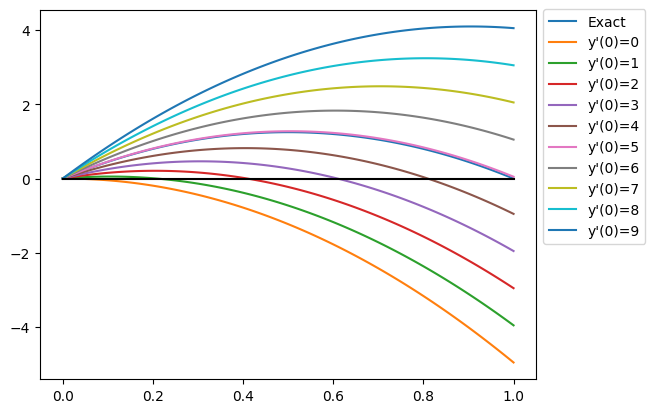

In [33]:
plt.plot(xs, ys_exact, label="Exact");
for i in range(len(w_shoots)):
    plt.plot(xs, w_shoots[i], label="y'(0)=" + str(i));
plt.plot(xs, [0 for _ in range(len(xs))], c='black');
plt.legend(bbox_to_anchor=(1., 1.02));

## Example for Boundary Value PDE (Finite Differences)

We consider the 1D heat equation:
$$\partial_{x}^2 u(t,x) = \partial_t u(t,x)\,,\quad u(t,0)=0=u(t,1)\,,\quad u(0,x)=u_0(x)=-e^{-10/4} + e^{-10(x-1/2)^2} $$

We want to solve the problem for $x\in[0,1]$ and $t\in[0,5]$. We discretize $x$ in steps $h=.1$ and $t$ in steps $k=.001$. The method converges if $k/h^2\leq .5$

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [29]:
def finite_difference(u_n):
    u_next = [0 for _ in range(len(u_n))]
    for j in range(1, len(u_n) - 1):
        u_next[j] = k/h**2 * (u_n[j+1] - 2 * u_n[j] + u_n[j-1]) + u_n[j]
    return u_next
    

In [30]:
h, k = .1, .002
ts = np.arange(0, .2 + .1*k, k)
xs = np.arange(0, 1 + .1*h, h)
us = [(-np.exp(-10/4) + np.exp(-10 * (xs - .5)**2)).tolist()]

In [31]:
for t in ts:
    us.append(finite_difference(us[-1]))

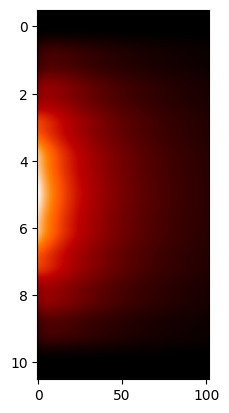

In [33]:
plt.imshow(np.transpose(us), cmap='gist_heat',aspect=20);

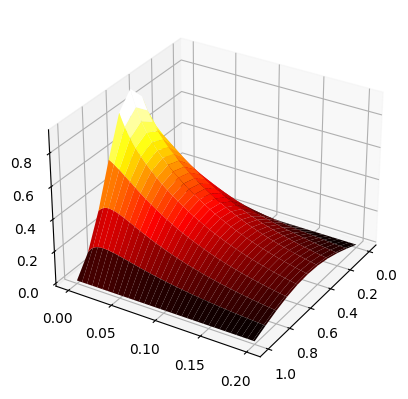

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(xs, ts)

ax.plot_surface(X, Y, np.array(us)[:-1], cmap='hot');
ax.view_init(30., np.pi/.1, 0.);